# 二手车数据分析和售价预测

数据获取主要通过requests和xpath进行爬取，数据来自汽车之家二手车数据。爬取的同时进行简单清洗，删除数据中的单位名称，最后使用pandas把重复数据删除后，再保存下来。

数据清洗包括单列拆分多列，缺失值填充，分组，异常值处理，数据类型转换等。

数据分析主要从以下10个方面进行分析：
1. 销售量最多的城市是哪些？及其原因？
2. 哪个城市的均价最高？均价高的城市有什么特点？
3. 大部分二手车的行驶里程集中在哪个区间？
4. 行驶里程与价格的关系？
5. 哪种排放标准的车出售量最多？
6. 未上牌的都是什么样的车，售价如何？
7. 各车龄占比多少？
8. 车龄和均价的关系如何？
9. 人们更喜欢手动还是自动挡的车？
10. 不同品牌的售价差异？
这些信息可以帮助客户简单了解二手车市场的情况。

预测售价采用了回归树模型，使用网格搜索交叉验证的方法进行最优参数的选择，使用R^2进行模型评估。
相比普通线性回归来说，树回归收敛速度更快，准确率也更高，对于复杂的数据来说，树回归通常有更好的处理效果。
这可以帮助买家或卖家对将要购买或出售的车量进行价格评估分析，帮助他们做出更好的决策。

## 数据获取

In [39]:
from lxml import etree
import requests
import time
import pandas as pd

In [40]:
def get_info(header, url01, url02, url03, brand, page):
    info_list = []
    for i in range(1,page):
        url = url01 + str(brand) + url02 + str(i) + url03
        html = requests.get(url, headers=header)
        time.sleep(1)
        selector = etree.HTML(html.text)    
        
        cars = selector.xpath('//*[@id="viewlist_div"]/div')  # type(cars) --> list
        prices = selector.xpath('//*[@class = "price-box"]/span[1]/text()') 
        j = 0
        for car in cars:
            title = car.xpath('div[2]/a/text()')[0]
            distance = car.xpath('div[3]/ul/li[1]/span/text()')[0].strip('万公里')
            license_time = car.xpath('div[3]//ul/li[2]/span/text()')[0]
            gears_displacement = car.xpath('div[3]/ul/li[3]/span/text()')[0]
            city = car.xpath('div[3]/ul/li[4]/span/text()')[0]
            emission_standard = car.xpath('div[3]/ul/li[5]/span/text()')[0]
            transfer = car.xpath('div[3]/ul/li[6]/span/text()')[0].strip('次')
            price = prices[j]
            j+=1
            info = {'Brand': brand, 'Title': title, 'Distance(ten thousand km)': distance, 'License_time': license_time, 'Gears_Displacement': gears_displacement, 'City': city, 
                    'Emission_standard': emission_standard, 'Transfer': transfer, 'Price( ten thousand yuan GDP)': price}
            info_list.append(info)
    return(info_list)

In [ ]:
header = {
    'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.23 Mobile Safari/537.36'
}

url01 = 'https://www.che168.com/china/'
url02 = '/a0_0msdgscncgpi1ltocsp'
url03 = 'exx0/'

brands = ['dazhong', 'fengtian', 'baoma', 'aodi', 'benchi', 'bentian', 'richan', 'bieke', 'fute', 'baoshijie', 'xiandai', 'mazida', 'luhu', 'leikesasi', 'xuefolan']

page = 301
try:
    for brand in brands:
        info_list = get_info(header, url01, url02, url03, brand, page)
    df = pd.DataFrame(info_list)
    df.drop_duplicates(inplace=True)
    df.to_csv('cars.csv', encoding='gb2312')
except Exception as e:
    print('Exception: ',e)

## 数据加载

In [12]:
import pandas as pd
import numpy as np
# 从csv中读取数据
data = pd.read_csv('cars.csv', encoding='gb2312', index_col=0) # index_col=0防止出现unnamed:0
data.head()

,Brand,City,Distance(ten thousand km),Emission_standard,Gears_Displacement,License_time,Price( ten thousand yuan GDP),Title,Transfer
0,奥迪,上海,1.22,国V,自动／3L,Aug-18,78.00,奥迪Q7 2016款 45 TFSI S line运动型,0
1,奥迪,深圳,7.00,国IV,自动／2L,May-11,13.50,奥迪A4L 2011款 2.0 TFSI 标准型,0
2,奥迪,郑州,7.80,欧IV,自动／2L,Nov-11,14.80,奥迪A6L 2011款 2.0 TFSI 自动标准型,1
3,奥迪,上海,6.22,欧IV,自动／3.2L,Mar-11,19.98,奥迪A5 2010款 3.2 coupe quattro,1
4,奥迪,沈阳,5.30,国IV(国V),自动／3L,Jan-12,42.80,奥迪A8 2012款 A8L 50 TFSI quattro尊贵型,1


In [5]:
print('热销品牌在售二手车数量：{}'.format(len(data)))

热销品牌在售二手车数量：81282


## 数据清洗

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81282 entries, 0 to 81281
Data columns (total 9 columns):
Brand                            81282 non-null object
City                             81282 non-null object
Distance(ten thousand km)        81282 non-null float64
Emission_standard                81282 non-null object
Gears_Displacement               81282 non-null object
License_time                     81282 non-null object
Price( ten thousand yuan GDP)    81282 non-null float64
Title                            81282 non-null object
Transfer                         81282 non-null object
dtypes: float64(2), object(7)
memory usage: 6.2+ MB


In [2]:
data.isnull().sum()

Brand                            0
City                             0
Distance(ten thousand km)        0
Emission_standard                0
Gears_Displacement               0
License_time                     0
Price( ten thousand yuan GDP)    0
Title                            0
Transfer                         0
dtype: int64

In [13]:
# 分离档位/排量
Gears_Displacement = data['Gears_Displacement'].str.split('／',expand=True)
Gears_Displacement.columns = ['Gears', 'Displacement']
data = data.join(Gears_Displacement)

In [14]:
data['Displacement'] = data['Displacement'].str.strip('L')
data.head()

,Brand,City,Distance(ten thousand km),Emission_standard,Gears_Displacement,License_time,Price( ten thousand yuan GDP),Title,Transfer,Gears,Displacement
0,奥迪,上海,1.22,国V,自动／3L,Aug-18,78.00,奥迪Q7 2016款 45 TFSI S line运动型,0,自动,3
1,奥迪,深圳,7.00,国IV,自动／2L,May-11,13.50,奥迪A4L 2011款 2.0 TFSI 标准型,0,自动,2
2,奥迪,郑州,7.80,欧IV,自动／2L,Nov-11,14.80,奥迪A6L 2011款 2.0 TFSI 自动标准型,1,自动,2
3,奥迪,上海,6.22,欧IV,自动／3.2L,Mar-11,19.98,奥迪A5 2010款 3.2 coupe quattro,1,自动,3.2
4,奥迪,沈阳,5.30,国IV(国V),自动／3L,Jan-12,42.80,奥迪A8 2012款 A8L 50 TFSI quattro尊贵型,1,自动,3


In [15]:
# 分离年，月
License_time = data['License_time'].str.split('-',expand=True)
License_time.columns = ['month', 'year']
data = data.join(License_time)

In [16]:
data['year'].unique()

array(['18', '11', '12', '16', '13', '14', '15', '17', None, '10', '08',
       '07', '09', '04', '05', '06', '03', '02', '91', '94', '00', '98',
       '96', '01', '20', '99', '95', '97'], dtype=object)

In [17]:
data['month'].unique()

array(['Aug', 'May', 'Nov', 'Mar', 'Jan', 'Jun', 'Oct', 'Feb', 'Sep',
       'Apr', 'Dec', '未上牌', 'Jul'], dtype=object)

In [18]:
# year中的空缺值指的是未上牌的车辆，这些车辆的使用时间通常不超过1年，因此为了给下一步进行使用年限的分类，以2018年作为时间填充
data['year'].fillna('18', inplace=True)
data['year'] = data['year'].astype(int)
data['year'].unique()

array([18, 11, 12, 16, 13, 14, 15, 17, 10,  8,  7,  9,  4,  5,  6,  3,  2,
       91, 94,  0, 98, 96,  1, 20, 99, 95, 97])

In [19]:
# 这里以上牌时间距离2018年的时间作为使用年限
def use_age(year):
    if year in range(14,19):
            use_age = '0~5'
    elif year in range(10,14):
            use_age = '6~10'
    else:
            use_age = 'over 10'
    return use_age

data['use_age'] = data['year'].map(use_age)

data.head()

,Brand,City,Distance(ten thousand km),Emission_standard,Gears_Displacement,License_time,Price( ten thousand yuan GDP),Title,Transfer,Gears,Displacement,month,year,use_age
0,奥迪,上海,1.22,国V,自动／3L,Aug-18,78.00,奥迪Q7 2016款 45 TFSI S line运动型,0,自动,3,Aug,18,0~5
1,奥迪,深圳,7.00,国IV,自动／2L,May-11,13.50,奥迪A4L 2011款 2.0 TFSI 标准型,0,自动,2,May,11,6~10
2,奥迪,郑州,7.80,欧IV,自动／2L,Nov-11,14.80,奥迪A6L 2011款 2.0 TFSI 自动标准型,1,自动,2,Nov,11,6~10
3,奥迪,上海,6.22,欧IV,自动／3.2L,Mar-11,19.98,奥迪A5 2010款 3.2 coupe quattro,1,自动,3.2,Mar,11,6~10
4,奥迪,沈阳,5.30,国IV(国V),自动／3L,Jan-12,42.80,奥迪A8 2012款 A8L 50 TFSI quattro尊贵型,1,自动,3,Jan,12,6~10


In [20]:
# 对行驶距离进行分组, 分为近距离，远距离和中等距离
bin_edges = [ 0.01, 3.00, 10.00, 57.00]
bin_names = ['near', 'mid', 'far']
data['Distance_levels'] = pd.cut(data['Distance(ten thousand km)'], bin_edges, labels=bin_names)
data.head()

,Brand,City,Distance(ten thousand km),Emission_standard,Gears_Displacement,License_time,Price( ten thousand yuan GDP),Title,Transfer,Gears,Displacement,month,year,use_age,Distance_levels
0,奥迪,上海,1.22,国V,自动／3L,Aug-18,78.00,奥迪Q7 2016款 45 TFSI S line运动型,0,自动,3,Aug,18,0~5,near
1,奥迪,深圳,7.00,国IV,自动／2L,May-11,13.50,奥迪A4L 2011款 2.0 TFSI 标准型,0,自动,2,May,11,6~10,mid
2,奥迪,郑州,7.80,欧IV,自动／2L,Nov-11,14.80,奥迪A6L 2011款 2.0 TFSI 自动标准型,1,自动,2,Nov,11,6~10,mid
3,奥迪,上海,6.22,欧IV,自动／3.2L,Mar-11,19.98,奥迪A5 2010款 3.2 coupe quattro,1,自动,3.2,Mar,11,6~10,mid
4,奥迪,沈阳,5.30,国IV(国V),自动／3L,Jan-12,42.80,奥迪A8 2012款 A8L 50 TFSI quattro尊贵型,1,自动,3,Jan,12,6~10,mid


In [21]:
data.Transfer.unique()
# Tansfer代表过户次数，次数过多的可以当成异常值处理

array(['0', '1', '2', '3', '6', '4', '5', '8', '99', '-', '30', '7', '9',
       '10'], dtype=object)

In [22]:
print('过户次数为99的有{}辆车'.format(data[data.Transfer=='99'].Transfer.count()))
print('过户次数为30的有{}辆车'.format(data[data.Transfer=='30'].Transfer.count()))
print('没有记录过户次数的辆车有{}辆'.format(data[data.Transfer=='-'].Transfer.count()))

过户次数为99的有6辆车
过户次数为30的有1辆车
没有记录过户次数的辆车有2622辆


In [23]:
data[(data.Transfer=='10') & (data.use_age=='0~5')]
# 35499行驶距离才0.3万千米，上牌时间为2017年，也就是说只有1年时间，但是却过户了10次，这个也当成异常值处理。

,Brand,City,Distance(ten thousand km),Emission_standard,Gears_Displacement,License_time,Price( ten thousand yuan GDP),Title,Transfer,Gears,Displacement,month,year,use_age,Distance_levels
35499,大众,青岛,0.3,国V,自动／1.2L,Jul-17,12.68,速腾 2017款 180TSI 自动领先型,10,自动,1.2,Jul,17,0~5,near


In [24]:
outliers=[] # 存放异常值的index
outliers.extend(data[data.Transfer=='30'].index.tolist())
outliers.extend(data[data.Transfer=='99'].index.tolist())
outliers.extend(data[(data.Transfer=='10') & (data.use_age=='0~5')].index.tolist())
outliers.extend(data[data.Transfer=='-'].index.tolist())
len(outliers)

2630

In [25]:
data['Transfer'].describe()

count     81282
unique       14
top           0
freq      46972
Name: Transfer, dtype: object

In [26]:
# 为了避免异常值造成不利影响，先把异常值全部变为众数0
for i in outliers:
    data.loc[i, 'Transfer'] = 0

In [27]:
# 进行数据类型转换
data.info()
data['Transfer'] = data['Transfer'].astype(int)
data['Displacement'] = data['Displacement'].astype(float)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81282 entries, 0 to 81281
Data columns (total 15 columns):
Brand                            81282 non-null object
City                             81282 non-null object
Distance(ten thousand km)        81282 non-null float64
Emission_standard                81282 non-null object
Gears_Displacement               81282 non-null object
License_time                     81282 non-null object
Price( ten thousand yuan GDP)    81282 non-null float64
Title                            81282 non-null object
Transfer                         81282 non-null object
Gears                            81282 non-null object
Displacement                     81282 non-null object
month                            81282 non-null object
year                             81282 non-null int64
use_age                          81282 non-null object
Distance_levels                  80653 non-null category
dtypes: category(1), float64(2), int64(1), object(11)
memory us

In [28]:
data.to_csv('cleaned_cars.csv', encoding='gb2312')

## 数据分析及探索

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import *    
from IPython.display import display
%matplotlib inline
myfont = FontProperties(fname='/Users/jia/Library/Fonts/SimHei.ttf') 
matplotlib.rcParams['axes.unicode_minus']=False

In [30]:
# 加载数据
data = pd.read_csv('cleaned_cars.csv', encoding='gb2312', index_col=0) # index_col=0防止出现unnamed:0

## 感兴趣的问题：
1. 销售量最多的城市是哪些？及其原因？
2. 哪个城市的均价最高？均价高的城市有什么特点？
3. 大部分二手车的行驶里程集中在哪个区间？
4. 行驶里程与售价的关系？
5. 哪种排放标准的车出售量最多？
6. 未上牌的都是什么样的车，售价如何？
7. 各车龄占比多少？
8. 车龄和均价的关系如何？
9. 人们更喜欢手动还是自动？
10. 不同品牌的售价差异？

————————————————————————————————————————————————————————————————————————————————————————————————————————————————

In [31]:
# 求出每个城市二手车的销售量，并按降序排列
city_num = data.groupby('City')['Title'].count().reset_index().sort_values('Title', ascending=False)

In [32]:
city_num.head(10)

,City,Title
5,上海,7108
196,温州,3276
240,苏州,2727
130,成都,2712
194,深圳,2355
278,郑州,2336
43,北京,2240
7,东莞,2156
112,广州,2151
46,南京,2085


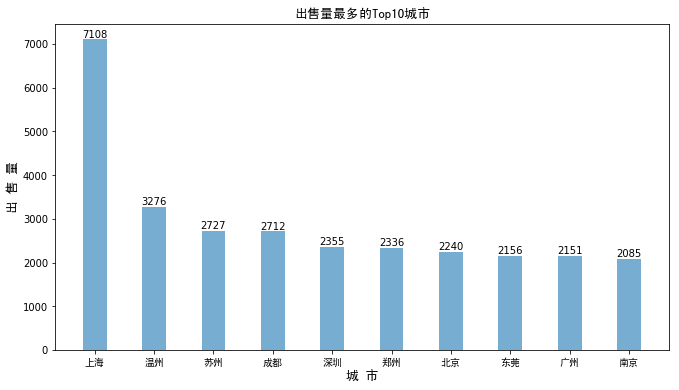

In [33]:
fig = plt.figure(figsize=(11,6))

labels = city_num['City'][:10]
x = np.arange(len(labels))
height = city_num['Title'][:10]
b = plt.bar(x, height, align='center', alpha=0.6, width=0.4)
plt.xticks(x, labels, fontproperties=myfont)
for x,h in zip(x,height):
    plt.text(x, h+0.05, '%.0f' % int(h),ha='center', va='bottom',fontsize=10)
plt.xlabel('城 市',fontproperties=myfont,fontsize=13)
plt.ylabel('出 售 量',fontproperties=myfont,fontsize=13)
plt.title('出售量最多的Top10城市',fontproperties=myfont,fontsize=13)
plt.show()

In [34]:
# 求销售量前10的城市占比
p = np.round(sum(city_num['Title'][:10]) / len(data), decimals = 2)
p_ = 1 - p

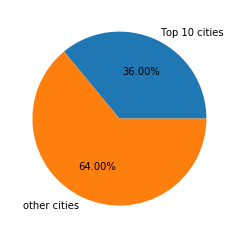

In [35]:
labels = 'Top 10 cities', 'other cities'
size = [p, p_]
plt.axes(aspect=1)
plt.pie(size, labels=labels, autopct='%0.2f%%')
plt.show()

In [36]:
city_price = data.groupby('City')['Price( ten thousand yuan GDP)'].mean().reset_index().sort_values('Price( ten thousand yuan GDP)', ascending=False)
city_price.head()

,City,Price( ten thousand yuan GDP)
27,伊春,82.000000
3,三沙,77.060000
305,陇南,57.093333
122,德宏,49.820000
55,双鸭山,42.720000


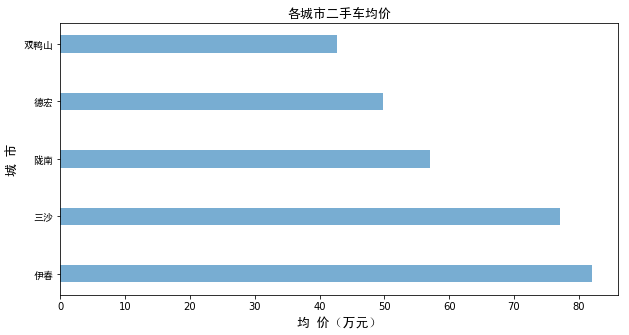

In [37]:
fig = plt.figure(figsize=(10,5))

labels = city_price['City'][:5]
y = np.arange(len(labels))
width = city_price['Price( ten thousand yuan GDP)'][:5]
plt.barh(y, width, align='center', alpha=0.6, height=0.3)
plt.yticks(y, labels, fontproperties=myfont)
plt.xlabel('均 价（万元）',fontproperties=myfont,fontsize=13)
plt.ylabel('城 市',fontproperties=myfont,fontsize=13)
plt.title('各城市二手车均价',fontproperties=myfont,fontsize=13)
plt.show()

#### 1. 在售量最多的城市是哪些？及其原因？
从城市相关数据来看，二手车出售基本集中在一线城市或新一线城市，前10个城市的在售量约占了总量的36%，其中上海的出售量最多，达到7108，与第二个城市温州3276量相比，高出了近两倍。
导致上海出售量特别多的原因有以下几个可能原因：1. 上海是大型一线城市，人口数量和用车数量都较多；2. 数据不够全面，只爬取了一个时间的数据，无法进行时间前后对比，也仅仅是一个网站上的数据，还有很多数据没有爬取下来；3. 上海用户/商家可能更喜欢使用此网站进行信息发布。

#### 2. 哪个城市的均价最高？
对于均价而言，均价较高的城市都是二三线小城市，原因可能是这些城市小所以销售量也不大，如果正好有几辆价格较高的二手车在售，就会拉高总体的均价。

————————————————————————————————————————————————————————————————————————————————————————————————————————————————

In [38]:
distance_price = data.groupby('Distance_levels')['Price( ten thousand yuan GDP)'].mean().reset_index().sort_values('Price( ten thousand yuan GDP)',ascending=False)
distance_price

,Distance_levels,Price( ten thousand yuan GDP)
2,near,29.459496
1,mid,19.256321
0,far,15.704301


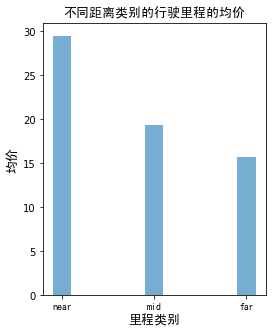

In [39]:
fig = plt.figure(figsize=(4,5))

labels = distance_price['Distance_levels']
x = np.arange(len(labels))
height = distance_price['Price( ten thousand yuan GDP)']
plt.bar(x, height, align='center', alpha=0.6, width=0.2)
plt.xticks(x, labels, fontproperties=myfont)
plt.xlabel('里程类别',fontproperties=myfont,fontsize=13)
plt.ylabel('均价',fontproperties=myfont,fontsize=13)
plt.title('不同距离类别的行驶里程的均价',fontproperties=myfont,fontsize=13)
plt.show()

In [40]:
distance_num = data.groupby('Distance_levels')['Title'].count()
distance_num

Distance_levels
far     10569
mid     51876
near    18208
Name: Title, dtype: int64

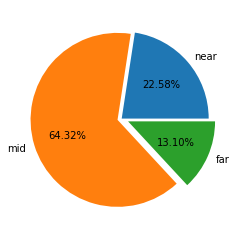

In [41]:
labels = 'near', 'mid', 'far'
size = [distance_num['near'], distance_num['mid'], distance_num['far']]
explode = [0, 0.05, 0.08]
plt.axes(aspect=1)
plt.pie(size, labels=labels, explode=explode, autopct='%0.2f%%')
plt.show()

#### 3. 大部分二手车的行驶里程集中在哪个区间？
大多数二手车的行驶距离都集中在中等程度的行驶距离，也就是说在3.0～10.0万公里的范围之内，占了64.32%。最少的是0.01万公里, 最多的是57万公里。

#### 4. 行驶里程与价格的关系？
从行驶距离和出售均价的柱状图也可以看出，行驶距离越短，则车相当越新，价格也越高，这是符合市场规律的，同时也说明车辆的行驶距离是影响其售价的一个重要因素。
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

In [42]:
emi_num = data.groupby('Emission_standard')['Title'].count().reset_index().sort_values('Title', ascending=False)
emi_num

,Emission_standard,Title
4,国IV(国V),23206
8,欧IV,20284
5,国V,12109
9,欧V,11255
3,国IV,9941
0,-,1506
7,欧III,1498
2,国III,795
10,欧VI,655
6,欧II,17


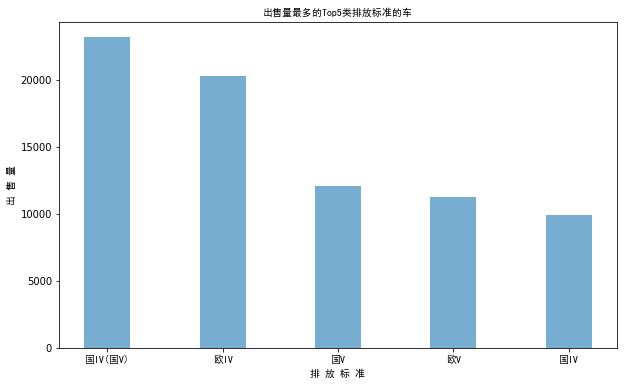

In [43]:
fig = plt.figure(figsize=(10,6))

labels = emi_num['Emission_standard'][:5]
x = np.arange(len(labels))
height = emi_num['Title'][:5]
plt.bar(x, height, align='center', alpha=0.6, width=0.4)
plt.xticks(x, labels, fontproperties=myfont)
plt.xlabel('排 放 标 准',fontproperties=myfont)
plt.ylabel('出 售 量',fontproperties=myfont)
plt.title('出售量最多的Top5类排放标准的车',fontproperties=myfont)
plt.show()

#### 5. 哪种排放标准的车出售量最多？
从图中可见在售车辆中排放标准最多的是IV或V，III或II的排放标准明显要少很多。
这说明了，各城市在控制汽车尾气排放量，实行环境保护上都做了相应的规定；同时汽车厂商在生产汽车时也注意生产更多满足要求的排放标准的车辆。
————————————————————————————————————————————————————————————————————————————————————————————————————————————————

In [44]:
len(data[data['month']=='未上牌'])

430

In [45]:
without_license = len(data[data['month']=='未上牌'])
has_license = len(data) - without_license

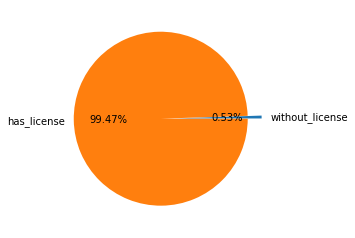

In [46]:
labels = 'without_license', 'has_license'
size = [without_license, has_license]
explode = [0.08, 0.08]
plt.axes(aspect=1)
plt.pie(size, labels=labels, explode=explode, autopct='%0.2f%%')
plt.show()

In [47]:
without_license_price = data[data['month']=='未上牌']['Price( ten thousand yuan GDP)'].mean()
has_license_price = data[data['month']!='未上牌']['Price( ten thousand yuan GDP)'].mean()
print('The mean of without license price: ',without_license_price)
print('The mean of has license price: ',has_license_price)

The mean of without license price:  56.71590697674413
The mean of has license price:  21.128031464899315


In [48]:
without_license_distance = data[data['month']=='未上牌']['Distance(ten thousand km)'].mean()
has_license_distance = data[data['month']!='未上牌']['Distance(ten thousand km)'].mean()
print('without_license_distance: ', without_license_distance)
print('has_license_distance: ', has_license_distance)

without_license_distance:  0.26883720930232724
has_license_distance:  6.372759610151505


#### 6. 未上牌的都是什么样的车，售价如何？
在售车辆中未上牌的车辆有430量，占总数的0.53%，这类车虽说是二手车，但售价上远高于其他二手车，而且行驶的里程普遍非常短，接近于新车，
所以说这类车通常是还未来得及上牌的“准新车”，这说明了在二手车市场，有一部分客户因各种各样的原因，会出售那些没开过多少次的车，售价低于新车而又高于普通二手车。
——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

In [49]:
use_age_num = data.groupby('use_age')['Title'].count()

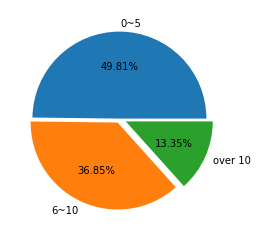

In [50]:
labels = '0~5', '6~10', 'over 10'
size = [use_age_num['0~5'], use_age_num['6~10'], use_age_num['over 10']]
explode = [0, 0.05, 0.08] 
plt.axes(aspect=1)
plt.pie(size, labels=labels, explode=explode, autopct='%0.2f%%')
plt.show()

In [51]:
use_age_price = data.groupby('use_age')['Price( ten thousand yuan GDP)'].mean().reset_index().sort_values('Price( ten thousand yuan GDP)', ascending=False)
use_age_price.head()

,use_age,Price( ten thousand yuan GDP)
0,0~5,27.765942
1,6~10,17.131362
2,over 10,8.803286


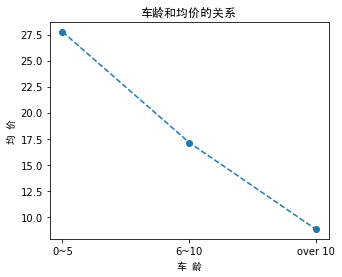

In [52]:
fig = plt.figure(figsize=(5,4))
x = ['0~5', '6~10', 'over 10']
plt.plot(x,use_age_price['Price( ten thousand yuan GDP)'], 'o--')
plt.xlabel('车 龄',fontproperties=myfont)
plt.ylabel('均 价',fontproperties=myfont)
plt.title('车龄和均价的关系',fontproperties=myfont, fontsize=12)
plt.show()

#### 7. 各车龄占比多少？
车龄为0～5年间占最大部分，为49.81%，约占所有出售车量中的一半，而车龄超过10年的最少，只有13.35%。
说明大部分出售二手车的客户会在车量使用到0～5年就进行出售了。
#### 8. 车龄和均价的关系如何？
从车龄和均价图可以看出，随着车龄的增加，售价几乎呈线性递减的，可见车龄是影响售价的一个关键因素。
——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

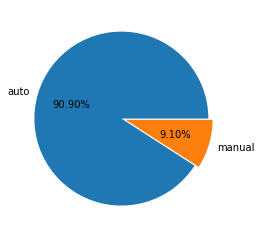

In [53]:
gear = data.groupby('Gears')['Title'].count()
labels = 'auto', 'manual'
explode = [0, 0.05]
size = [gear['自动'], gear['手动']]
plt.axes(aspect=1)
plt.pie(size, labels=labels, explode=explode, autopct='%0.2f%%')
plt.show()

In [54]:
data.groupby('Gears')['Price( ten thousand yuan GDP)'].mean().reset_index().sort_values('Price( ten thousand yuan GDP)', ascending=False)


,Gears,Price( ten thousand yuan GDP)
1,自动,22.918879
0,手动,5.306540


#### 9. 人们更喜欢手动还是自动？
从销售量来说，自动挡的车占到90.9%，而手动挡的只有9.1%，出售量越多在一定程度上就能说明客户喜欢购买的是什么样的车。
从平均售价上看，自动挡的也远远高于手动挡的车。
结合两方面看，档位是影响售价的一个重要因素。

————————————————————————————————————————————————————————————————————————————————————————————

In [55]:
brand_price = data.groupby('Brand')['Price( ten thousand yuan GDP)'].mean().reset_index().sort_values('Price( ten thousand yuan GDP)', ascending=False)
brand_price

,Brand,Price( ten thousand yuan GDP)
0,保时捷,60.342025
10,路虎,48.188905
3,奔驰,35.103502
12,雷克萨斯,29.155432
5,宝马,28.184517
4,奥迪,24.662537
9,福特,12.407072
2,大众,11.749674
7,本田,11.227901
6,日产,10.895022


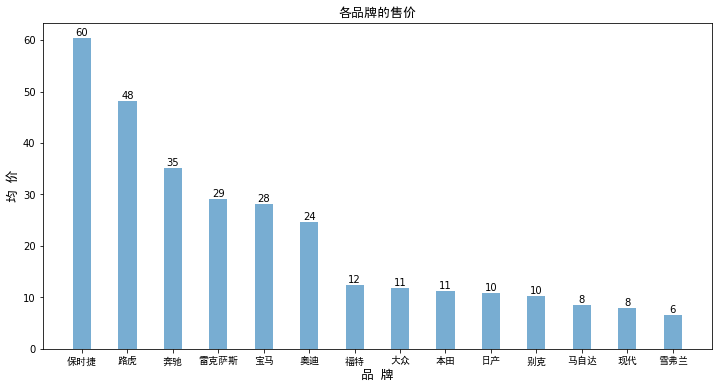

In [56]:
fig = plt.figure(figsize=(12,6))

labels = brand_price['Brand']
x = np.arange(len(labels))
height = brand_price['Price( ten thousand yuan GDP)']
b = plt.bar(x, height, align='center', alpha=0.6, width=0.4)
plt.xticks(x, labels, fontproperties=myfont)
for x,h in zip(x,height):
    plt.text(x, h+0.05, '%.0f' % int(h),ha='center', va='bottom',fontsize=10)
plt.xlabel('品 牌',fontproperties=myfont,fontsize=13)
plt.ylabel('均 价',fontproperties=myfont,fontsize=13)
plt.title('各品牌的售价',fontproperties=myfont,fontsize=13)
plt.show()

In [57]:
baoshijie = data[data['Brand']=='保时捷']
baoshijie_use_age = baoshijie.groupby('use_age')['use_age'].count()

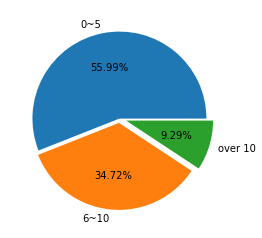

In [58]:
labels = '0~5', '6~10', 'over 10'
size = [baoshijie_use_age['0~5'], baoshijie_use_age['6~10'], baoshijie_use_age['over 10']]
explode = [0, 0.05, 0.08]
plt.axes(aspect=1)
plt.pie(size, labels=labels, autopct='%0.2f%%', explode=explode)
plt.show()

#### 10. 不同品牌的售价差异？ 
从图中可以看到保时捷，路虎，奔驰的售价最高，其中保时捷售价最高约为60万元。

进一步分析，除了品牌原因外，保时捷0～5年车龄的比例也比较高。
————————————————————————————————————————————————————————————————————————————————————————————

## 模型构建

### 数据预处理
在将数据作为机器学习算法的输入之前，通常必须整理数据、调整数据格式和结构，这一流程通常称之为预处理。

In [1]:
# 加载数据
import pandas as pd
import numpy as np
data = pd.read_csv('cleaned_cars.csv', encoding='gb2312', index_col=0)
data.head()

,Brand,City,Distance(ten thousand km),Emission_standard,Gears_Displacement,License_time,Price( ten thousand yuan GDP),Title,Transfer,Gears,Displacement,month,year,use_age,Distance_levels
0,奥迪,上海,1.22,国V,自动／3L,Aug-18,78.00,奥迪Q7 2016款 45 TFSI S line运动型,0,自动,3.0,Aug,18,0~5,near
1,奥迪,深圳,7.00,国IV,自动／2L,May-11,13.50,奥迪A4L 2011款 2.0 TFSI 标准型,0,自动,2.0,May,11,6~10,mid
2,奥迪,郑州,7.80,欧IV,自动／2L,Nov-11,14.80,奥迪A6L 2011款 2.0 TFSI 自动标准型,1,自动,2.0,Nov,11,6~10,mid
3,奥迪,上海,6.22,欧IV,自动／3.2L,Mar-11,19.98,奥迪A5 2010款 3.2 coupe quattro,1,自动,3.2,Mar,11,6~10,mid
4,奥迪,沈阳,5.30,国IV(国V),自动／3L,Jan-12,42.80,奥迪A8 2012款 A8L 50 TFSI quattro尊贵型,1,自动,3.0,Jan,12,6~10,mid


In [2]:
# 删除重复意义的特征
data_ = data.drop(['Gears_Displacement', 'License_time', 'Title', 'Distance_levels'], axis=1)

### 对数字特征进行标准化
对数据进行缩放不会更改每个特征的分布形状；但是，标准化可以确保在应用监督式学习器时，能够平等地对待每个特征。但应用缩放之后，原始形式的数据将不再具有相同的原始含义。

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Distance(ten thousand km)', 'Price( ten thousand yuan GDP)', 'Transfer', 'Displacement']
data[numerical] = scaler.fit_transform(data[numerical])
data.head()

,Brand,City,Distance(ten thousand km),Emission_standard,Gears_Displacement,License_time,Price( ten thousand yuan GDP),Title,Transfer,Gears,Displacement,month,year,use_age,Distance_levels
0,奥迪,上海,0.021232,国V,自动／3L,Aug-18,0.042970,奥迪Q7 2016款 45 TFSI S line运动型,0.0,自动,0.441176,Aug,18,0~5,near
1,奥迪,深圳,0.122653,国IV,自动／2L,May-11,0.007309,奥迪A4L 2011款 2.0 TFSI 标准型,0.0,自动,0.294118,May,11,6~10,mid
2,奥迪,郑州,0.136691,欧IV,自动／2L,Nov-11,0.008028,奥迪A6L 2011款 2.0 TFSI 自动标准型,0.1,自动,0.294118,Nov,11,6~10,mid
3,奥迪,上海,0.108966,欧IV,自动／3.2L,Mar-11,0.010892,奥迪A5 2010款 3.2 coupe quattro,0.1,自动,0.470588,Mar,11,6~10,mid
4,奥迪,沈阳,0.092823,国IV(国V),自动／3L,Jan-12,0.023508,奥迪A8 2012款 A8L 50 TFSI quattro尊贵型,0.1,自动,0.441176,Jan,12,6~10,mid


### 转换非数字特征
通常，学习算法都预期输入是数字，这就需要转换非数字特征（称为分类变量）。一种转换分类变量的常见方式是独热编码方法。独热编码会为每个非数字特征的每个可能类别创建一个_“虚拟”_变量。例如，假设 someFeature 有三个潜在条目：A、B 或 C。我们将此特征编码为 someFeature_A、someFeature_B 和 someFeature_C。

In [4]:
data['year'].astype(object)
data = pd.get_dummies(data)

In [5]:
data.head()

,Distance(ten thousand km),Price( ten thousand yuan GDP),Transfer,Displacement,year,Brand_保时捷,Brand_别克,Brand_大众,Brand_奔驰,Brand_奥迪,...,month_Nov,month_Oct,month_Sep,month_未上牌,use_age_0~5,use_age_6~10,use_age_over 10,Distance_levels_far,Distance_levels_mid,Distance_levels_near
0,0.021232,0.042970,0.0,0.441176,18,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,0.122653,0.007309,0.0,0.294118,11,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,0.136691,0.008028,0.1,0.294118,11,0,0,0,0,1,...,1,0,0,0,0,1,0,0,1,0
3,0.108966,0.010892,0.1,0.470588,11,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,0.092823,0.023508,0.1,0.441176,12,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


### 数据拆分

In [6]:
# Split the data into features and target label
label = data['Price( ten thousand yuan GDP)']
features = data.drop('Price( ten thousand yuan GDP)', axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    label,
                                                    test_size = 0.2,
                                                    random_state = 0)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 65025 samples.
Testing set has 16257 samples.


### 模型构建

In [14]:
from sklearn.metrics import make_scorer, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit

def fit_model(X, y):
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
    regressor = DecisionTreeRegressor(random_state=42)
    params = {'max_depth': np.arange(25,30)} 
    scoring_fnc = make_scorer(r2_score)
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)
    grid = grid.fit(X, y)
    return grid.best_estimator_

In [15]:
reg = fit_model(X_train, y_train)
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 28 for the optimal model.


### 模型评估

In [11]:
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Optimal model has R^2 score {:,.2f} on test data".format(r2))

Optimal model has R^2 score 0.94 on test data
